![](https://images11.popmeh.ru/upload/img_cache/f69/f694ce60664fa7133e727a6f72cd8384_ce_2000x1050x0x265_fitted_1260x700.jpeg)

In [3]:
import numpy as np 
import pandas as pd
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier

pd.set_option('display.max_columns', None)

print("Setup completed")

Setup completed


In [13]:
users = pd.read_csv('../datasets/telecom_users.csv')

# Basic information

In [14]:
users.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


In [15]:
# Delete two unnecessary columns
users = users.drop(['Unnamed: 0', 'customerID'], axis = 1)

In [16]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5986 non-null   object 
 1   SeniorCitizen     5986 non-null   int64  
 2   Partner           5986 non-null   object 
 3   Dependents        5986 non-null   object 
 4   tenure            5986 non-null   int64  
 5   PhoneService      5986 non-null   object 
 6   MultipleLines     5986 non-null   object 
 7   InternetService   5986 non-null   object 
 8   OnlineSecurity    5986 non-null   object 
 9   OnlineBackup      5986 non-null   object 
 10  DeviceProtection  5986 non-null   object 
 11  TechSupport       5986 non-null   object 
 12  StreamingTV       5986 non-null   object 
 13  StreamingMovies   5986 non-null   object 
 14  Contract          5986 non-null   object 
 15  PaperlessBilling  5986 non-null   object 
 16  PaymentMethod     5986 non-null   object 


The missing values are actually there

Total charges there is as object, but this column contains float, so when I tried to change the column type, it returned an error, because there are missing values in the form of an empty string, let's fix it

In [17]:
missing_values = 0
for i in range(len(users.index)):
    if users['TotalCharges'][i].replace('.', '').isdigit() == False:
        users.iloc[i, 18] = '100'
        missing_values += 1
print(missing_values)
        
users['TotalCharges'] = users['TotalCharges'].astype('float')

10


There are 10 missing values. Therefore, you should always carefully double-check the data.

In [18]:
ch = {'Yes': 'Client left', 'No': 'Client stayed'}
users['Churn'] = users['Churn'].map(ch)

In [19]:
users.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,Client stayed
1,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.20,Client stayed
2,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Client left
3,Male,0,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.50,Client stayed
4,Male,0,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.50,Client stayed


# EDA

**Customer churn**

In [20]:
churn = users.groupby('Churn').agg({'Churn': 'count'}).rename(columns = {'Churn': 'count'}).reset_index()
churn

,Churn,count
0,Client left,1587
1,Client stayed,4399


In [22]:
fig = px.pie(churn, values = churn['count'], names = churn['Churn'])
fig.update_traces(textposition = 'inside', 
                  textinfo = 'percent + label', 
                  hole = 0.85, 
                  marker = dict(colors = ['#2A3132','#336B87'], line = dict(color = 'white', width = 2)))

fig.update_layout(title_text = 'Customer churn', title_x = 0.5, title_y = 0.53, title_font_size = 32, title_font_family = 'Calibri', title_font_color = 'black',
                  showlegend = False)
                  
fig.show()

**Affect of charges and duration of use on customer churn**

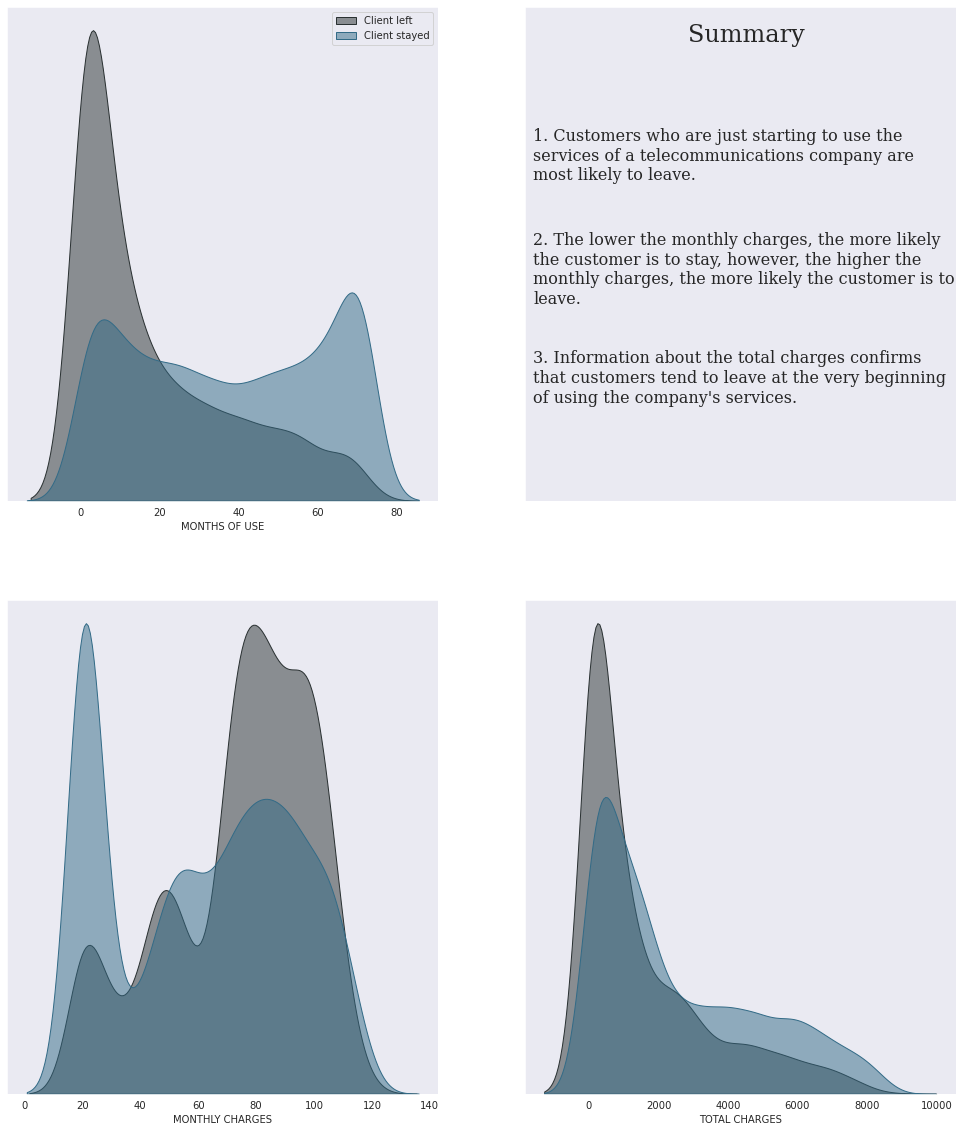

In [11]:
fig = plt.figure(figsize = (17, 20))

plt.subplot(221)
sns.set_style("dark")
sns.kdeplot(users.query('Churn == "Client left"')['tenure'], color = '#2A3132', shade = True, label = 'Client left', alpha = 0.5)
sns.kdeplot(users.query('Churn == "Client stayed"')['tenure'], color = '#336B87', shade = True, label = 'Client stayed', alpha = 0.5)
plt.ylabel('')
plt.xlabel('MONTHS OF USE')
plt.yticks([])
plt.legend()

plt.subplot(222)
plt.text(0.38, 0.93, 'Summary', fontsize = 24, fontfamily = 'serif', fontweight='light')
plt.text(0.02, 0.65, '''1. Customers who are just starting to use the 
services of a telecommunications company are
most likely to leave.''', fontsize = 16, fontfamily = 'serif', fontweight='light')
plt.text(0.02, 0.4, '''2. The lower the monthly charges, the more likely 
the customer is to stay, however, the higher the
monthly charges, the more likely the customer is to 
leave.''', fontsize = 16, fontfamily = 'serif', fontweight='light')
plt.text(0.02, 0.2, '''3. Information about the total charges confirms 
that customers tend to leave at the very beginning 
of using the company's services.''', fontsize = 16, fontfamily = 'serif', fontweight='light')
plt.yticks([])
plt.xticks([])

plt.subplot(223)
sns.set_style("dark")
sns.kdeplot(users.query('Churn == "Client left"')['MonthlyCharges'], color = '#2A3132', shade = True, label = 'Client left', alpha = 0.5)
sns.kdeplot(users.query('Churn == "Client stayed"')['MonthlyCharges'], color = '#336B87', shade = True, label = 'Client stayed', alpha = 0.5)
plt.ylabel('')
plt.xlabel('MONTHLY CHARGES')
plt.yticks([])

plt.subplot(224)
sns.set_style("dark")
sns.kdeplot(users.query('Churn == "Client left"')['TotalCharges'], color = '#2A3132', shade = True, label = 'Client left', alpha = 0.5)
sns.kdeplot(users.query('Churn == "Client stayed"')['TotalCharges'], color = '#336B87', shade = True, label = 'Client stayed', alpha = 0.5)
plt.ylabel('')
plt.xlabel('TOTAL CHARGES')
plt.yticks([])


plt.show()

**Affect of having a spouse and retirement on customer churn**

In [23]:
spouse = users.groupby(['Partner', 'Churn']).agg({'Churn': 'count'}).rename(columns = {'Churn': 'count'}).reset_index()
spouse.iloc[[0,1], 0] = 'Not married'
spouse.iloc[[2,3], 0] = 'Married'
spouse

,Partner,Churn,count
0,Not married,Client left,1011
1,Not married,Client stayed,2071
2,Married,Client left,576
3,Married,Client stayed,2328


In [24]:
SeniorCitizen = users.groupby(['SeniorCitizen', 'Churn']).agg({'Churn': 'count'}).rename(columns = {'Churn': 'count'}).reset_index()
SeniorCitizen.iloc[[0,1], 0] = 'Not pensioner'
SeniorCitizen.iloc[[2,3], 0] = 'Pensioner'
SeniorCitizen

,SeniorCitizen,Churn,count
0,Not pensioner,Client left,1185
1,Not pensioner,Client stayed,3835
2,Pensioner,Client left,402
3,Pensioner,Client stayed,564


In [26]:
fig = px.sunburst(SeniorCitizen, path = ['SeniorCitizen', 'Churn'], values = 'count', color = 'SeniorCitizen', title = 'Affect of retirement on customer churn',
                 color_discrete_map = {'Not pensioner': '#336B87', 'Pensioner': '#2A3132'},
                 width = 600, height = 600)

fig.update_layout(plot_bgcolor = 'white', title_font_family = 'Calibri Black', title_font_color = '#221f1f', title_font_size = 22, title_x = 0.5)

fig.update_traces(textinfo = 'label + percent parent')
                  
fig.show()
##########################
fig = px.sunburst(spouse, path = ['Partner', 'Churn'], values = 'count', color = 'Partner', title = 'Affect of having a spouse on customer churn',
                 color_discrete_map = {'Not married': '#336B87', 'Married': '#2A3132'},
                 width = 600, height = 600)

fig.update_layout(plot_bgcolor = 'white', title_font_family = 'Calibri Black', title_font_color = '#221f1f', title_font_size = 22, title_x = 0.5)

fig.update_traces(textinfo = 'label + percent parent')
                  
fig.show()

**Distribution of customer churn by phone and internet services**

In [27]:
phone = users.groupby(['PhoneService', 'Churn']).agg({'Churn': 'count'}).rename(columns = {'Churn': 'count'}).reset_index()
phone.iloc[[0,1], 0] = 'No phone service'
phone.iloc[[2,3], 0] = 'Yes phone service'
phone

,PhoneService,Churn,count
0,No phone service,Client left,149
1,No phone service,Client stayed,441
2,Yes phone service,Client left,1438
3,Yes phone service,Client stayed,3958


In [28]:
internet = users.groupby(['InternetService', 'Churn']).agg({'Churn': 'count'}).rename(columns = {'Churn': 'count'}).reset_index()
internet.iloc[[4,5], 0] = 'No internet'
internet

,InternetService,Churn,count
0,DSL,Client left,397
1,DSL,Client stayed,1671
2,Fiber optic,Client left,1091
3,Fiber optic,Client stayed,1536
4,No internet,Client left,99
5,No internet,Client stayed,1192


In [29]:
fig = px.sunburst(phone, path = ['PhoneService', 'Churn'], values = 'count', color = 'PhoneService', title = 'Distribution of customer churn by phone service',
                 color_discrete_map = {'No phone service': '#336B87', 'Yes phone service': '#2A3132'},
                 width = 600, height = 600)

fig.update_layout(plot_bgcolor = 'white', title_font_family = 'Calibri Black', title_font_color = '#221f1f', title_font_size = 22, title_x = 0.5)

fig.update_traces(textinfo = 'label + percent parent')
                  
fig.show()
#######################################
fig = px.sunburst(internet, path = ['InternetService', 'Churn'], values = 'count', color = 'InternetService', title = 'Distribution of customer churn by internet service',
                 color_discrete_map = {'DSL': '#336B87', 'Fiber optic': '#2A3132', 'No internet': '#763626'},
                 width = 600, height = 600)

fig.update_layout(plot_bgcolor = 'white', title_font_family = 'Calibri Black', title_font_color = '#221f1f', title_font_size = 22, title_x = 0.5)

fig.update_traces(textinfo = 'label + percent parent')
                  
fig.show()

**Distribution of customer churn by online security and backup**

In [30]:
i_sec = users.groupby(['OnlineSecurity', 'Churn']).agg({'Churn': 'count'}).rename(columns = {'Churn': 'count'}).reset_index()

i_sec

,OnlineSecurity,Churn,count
0,No,Client left,1242
1,No,Client stayed,1740
2,No internet service,Client left,99
3,No internet service,Client stayed,1192
4,Yes,Client left,246
5,Yes,Client stayed,1467


In [31]:
i_back = users.groupby(['OnlineBackup', 'Churn']).agg({'Churn': 'count'}).rename(columns = {'Churn': 'count'}).reset_index()

i_back

,OnlineBackup,Churn,count
0,No,Client left,1038
1,No,Client stayed,1567
2,No internet service,Client left,99
3,No internet service,Client stayed,1192
4,Yes,Client left,450
5,Yes,Client stayed,1640


In [32]:
fig = px.sunburst(i_sec, path = ['OnlineSecurity', 'Churn'], values = 'count', color = 'OnlineSecurity', title = 'Distribution of customer churn by online security',
                 color_discrete_map = {'No': '#336B87', 'Yes': '#2A3132', 'No internet service': '#763626'},
                 width = 600, height = 600)

fig.update_layout(plot_bgcolor = 'white', title_font_family = 'Calibri Black', title_font_color = '#221f1f', title_font_size = 22, title_x = 0.5)

fig.update_traces(textinfo = 'label + percent parent')
                  
fig.show()
#######################################
fig = px.sunburst(i_back, path = ['OnlineBackup', 'Churn'], values = 'count', color = 'OnlineBackup', title = 'Distribution of customer churn by online backup',
                 color_discrete_map = {'No': '#336B87', 'Yes': '#2A3132', 'No internet service': '#763626'},
                 width = 600, height = 600)

fig.update_layout(plot_bgcolor = 'white', title_font_family = 'Calibri Black', title_font_color = '#221f1f', title_font_size = 22, title_x = 0.5)

fig.update_traces(textinfo = 'label + percent parent')
                  
fig.show()

**Distribution of customer churn by device protection and tech support**

In [33]:
d_prot = users.groupby(['DeviceProtection', 'Churn']).agg({'Churn': 'count'}).rename(columns = {'Churn': 'count'}).reset_index()

d_prot

,DeviceProtection,Churn,count
0,No,Client left,1031
1,No,Client stayed,1609
2,No internet service,Client left,99
3,No internet service,Client stayed,1192
4,Yes,Client left,457
5,Yes,Client stayed,1598


In [34]:
t_supp = users.groupby(['TechSupport', 'Churn']).agg({'Churn': 'count'}).rename(columns = {'Churn': 'count'}).reset_index()

t_supp

,TechSupport,Churn,count
0,No,Client left,1222
1,No,Client stayed,1738
2,No internet service,Client left,99
3,No internet service,Client stayed,1192
4,Yes,Client left,266
5,Yes,Client stayed,1469


In [35]:
fig = px.sunburst(d_prot, path = ['DeviceProtection', 'Churn'], values = 'count', color = 'DeviceProtection', title = 'Distribution of customer churn by device protection',
                 color_discrete_map = {'No': '#336B87', 'Yes': '#2A3132', 'No internet service': '#763626'},
                 width = 600, height = 600)

fig.update_layout(plot_bgcolor = 'white', title_font_family = 'Calibri Black', title_font_color = '#221f1f', title_font_size = 22, title_x = 0.5)

fig.update_traces(textinfo = 'label + percent parent')
                  
fig.show()
#######################################
fig = px.sunburst(t_supp, path = ['TechSupport', 'Churn'], values = 'count', color = 'TechSupport', title = 'Distribution of customer churn by tech support',
                 color_discrete_map = {'No': '#336B87', 'Yes': '#2A3132', 'No internet service': '#763626'},
                 width = 600, height = 600)

fig.update_layout(plot_bgcolor = 'white', title_font_family = 'Calibri Black', title_font_color = '#221f1f', title_font_size = 22, title_x = 0.5)

fig.update_traces(textinfo = 'label + percent parent')
                  
fig.show()

**Distribution of customer churn by streaming services**

In [36]:
s_tv = users.groupby(['StreamingTV', 'Churn']).agg({'Churn': 'count'}).rename(columns = {'Churn': 'count'}).reset_index()

s_tv

,StreamingTV,Churn,count
0,No,Client left,799
1,No,Client stayed,1590
2,No internet service,Client left,99
3,No internet service,Client stayed,1192
4,Yes,Client left,689
5,Yes,Client stayed,1617


In [37]:
s_mov = users.groupby(['StreamingMovies', 'Churn']).agg({'Churn': 'count'}).rename(columns = {'Churn': 'count'}).reset_index()

s_mov

,StreamingMovies,Churn,count
0,No,Client left,792
1,No,Client stayed,1564
2,No internet service,Client left,99
3,No internet service,Client stayed,1192
4,Yes,Client left,696
5,Yes,Client stayed,1643


In [38]:
fig = px.sunburst(s_tv, path = ['StreamingTV', 'Churn'], values = 'count', color = 'StreamingTV', title = 'Distribution of customer churn by streaming TV',
                 color_discrete_map = {'No': '#336B87', 'Yes': '#2A3132', 'No internet service': '#763626'},
                 width = 600, height = 600)

fig.update_layout(plot_bgcolor = 'white', title_font_family = 'Calibri Black', title_font_color = '#221f1f', title_font_size = 22, title_x = 0.5)

fig.update_traces(textinfo = 'label + percent parent')
                  
fig.show()
#######################################
fig = px.sunburst(s_mov, path = ['StreamingMovies', 'Churn'], values = 'count', color = 'StreamingMovies', title = 'Distribution of customer churn by streaming movies',
                 color_discrete_map = {'No': '#336B87', 'Yes': '#2A3132', 'No internet service': '#763626'},
                 width = 600, height = 600)

fig.update_layout(plot_bgcolor = 'white', title_font_family = 'Calibri Black', title_font_color = '#221f1f', title_font_size = 22, title_x = 0.5)

fig.update_traces(textinfo = 'label + percent parent')
                  
fig.show()

**Distribution of customer churn by type of contract and method of payment**

In [39]:
contract = users.groupby(['Contract', 'Churn']).agg({'Churn': 'count'}).rename(columns = {'Churn': 'count'}).reset_index()

contract

,Contract,Churn,count
0,Month-to-month,Client left,1398
1,Month-to-month,Client stayed,1871
2,One year,Client left,148
3,One year,Client stayed,1128
4,Two year,Client left,41
5,Two year,Client stayed,1400


In [40]:
payment = users.groupby(['PaymentMethod', 'Churn']).agg({'Churn': 'count'}).rename(columns = {'Churn': 'count'}).reset_index()

payment

,PaymentMethod,Churn,count
0,Bank transfer (automatic),Client left,224
1,Bank transfer (automatic),Client stayed,1084
2,Credit card (automatic),Client left,198
3,Credit card (automatic),Client stayed,1105
4,Electronic check,Client left,902
5,Electronic check,Client stayed,1104
6,Mailed check,Client left,263
7,Mailed check,Client stayed,1106


In [41]:
fig = px.sunburst(contract, path = ['Contract', 'Churn'], values = 'count', color = 'Contract', title = 'Distribution of customer churn by type of contract',
                 color_discrete_map = {'Month-to-month': '#336B87', 'One year': '#2A3132', 'Two year': '#763626'},
                 width = 600, height = 600)

fig.update_layout(plot_bgcolor = 'white', title_font_family = 'Calibri Black', title_font_color = '#221f1f', title_font_size = 22, title_x = 0.5)

fig.update_traces(textinfo = 'label + percent parent')
                  
fig.show()
#######################################
fig = px.sunburst(payment, path = ['PaymentMethod', 'Churn'], values = 'count', color = 'PaymentMethod', title = 'Distribution of customer churn by method of payment',
                 color_discrete_map = {'Bank transfer (automatic)': '#336B87', 'Credit card (automatic)': '#2A3132', 
                                       'Electronic check': '#763626', 'Mailed check': '#90AFC5'},
                 width = 600, height = 600)

fig.update_layout(plot_bgcolor = 'white', title_font_family = 'Calibri Black', title_font_color = '#221f1f', title_font_size = 22, title_x = 0.5)

fig.update_traces(textinfo = 'label + percent parent')
                  
fig.show()

# Conclusions of the EDA

**The most important factors affecting customer churn:**

1. Pensioners and who are not married are more likely to leave.
2. The company has obvious problems with the Internet on fiber optic.
3. Lack of online security, online backup, device protection and technical support.
4. Customers who leave the company mostly have a month-to-month payment, сustomers who have a contract for 1 and 2 years almost do not leave the company.
5. Customers who pay for services by electronic check are more likely to leave the company than others.

# Preprocessing

In [42]:
X = users.drop('Churn', axis = 1)
rey = {'Client stayed': 0, 'Client left': 1}
users['Churn'] = users['Churn'].map(rey)
y = users['Churn']

num_cols = X.select_dtypes(include = ['int64', 'float64']).columns.to_list()
cat_cols = X.select_dtypes(include = ['object']).columns.to_list()

In [43]:
def label_encoder(df):
    for i in cat_cols:
        le = LabelEncoder()
        df[i] = le.fit_transform(df[i])
    return df

In [44]:
sc = StandardScaler()
X[num_cols] = sc.fit_transform(X[num_cols])

# Label encoding
X = label_encoder(X)

X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,1,-0.438669,1,1,1.612576,1,2,2,1,1,1,1,1,1,2,0,1,-1.351686,-0.246168
1,0,-0.438669,0,0,0.470387,1,0,1,0,2,2,0,2,0,0,1,1,0.775360,0.738326
2,0,2.279624,1,0,0.225633,1,2,1,0,0,0,0,0,0,0,1,0,0.336999,0.253083
3,1,-0.438669,0,0,-1.161310,1,0,0,0,0,0,0,0,2,0,1,2,-0.295635,-0.904161
4,1,-0.438669,0,0,-1.242895,1,0,0,2,0,2,0,0,0,0,0,2,-0.376997,-0.956496


# Modeling

**For this analysis I will use 5 models:**

1. Logistic Regression.
2. Random Forest.
3. LGBM.
4. XGB.

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 22)

Table for results

In [46]:
results = pd.DataFrame(columns = ['LR', 'RF', 'LGBM', 'XGB'], index = range(4))

# Logistic Regression

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       872
           1       0.67      0.55      0.60       326

    accuracy                           0.80      1198
   macro avg       0.76      0.72      0.74      1198
weighted avg       0.80      0.80      0.80      1198

ROC AUC score: 0.852

-----------------------------------------------------

Cross-validation scores with 5 folds:

ROC AUC: 0.841
precision: 0.65
recall: 0.54
f1: 0.59


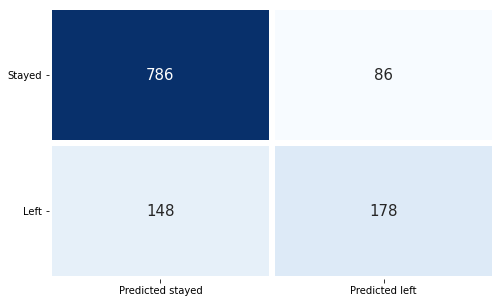

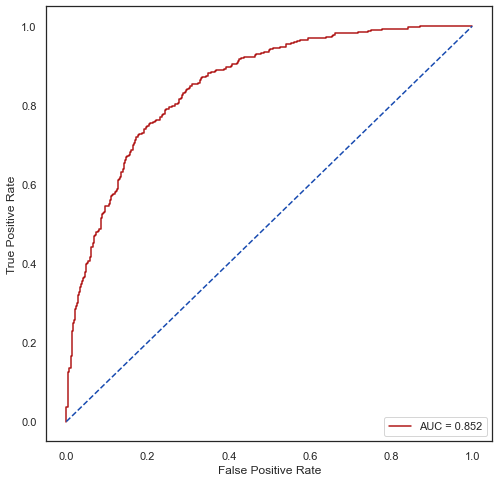

,feature,importance (abs coef)
4,tenure,1.327686
5,PhoneService,1.030563
14,Contract,0.750584
18,TotalCharges,0.622573
17,MonthlyCharges,0.600889
15,PaperlessBilling,0.336681
8,OnlineSecurity,0.285830
7,InternetService,0.243338
11,TechSupport,0.231785
9,OnlineBackup,0.178771


In [47]:
lg = LogisticRegression(random_state = 22)
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
y_prob = lg.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 0] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 0] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 0] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 0] = round(roc_auc_score(y_test, y_prob), 3)
lg_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 5 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(lg, X, y, cv = 5, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(lg, X, y, cv = 5, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(lg, X, y, cv = 5, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(lg, X, y, cv = 5, scoring = 'f1').mean(), 2)}")

# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(lg_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['Stayed', 'Left'], xticklabels = ['Predicted stayed', 'Predicted left'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Feature importance
f_imp = pd.DataFrame(columns = ['feature', 'importance (abs coef)'], index = range(19))
for i in range(len(f_imp.index)):
    f_imp.iloc[i, 0] = X_train.columns.to_list()[i]
f_imp['importance (abs coef)'] = abs(lg.coef_)[0]
f_imp = f_imp.sort_values('importance (abs coef)', ascending = False)
f_imp[0:12].style.background_gradient(cmap = 'Blues')

In [48]:
cross_val_score(lg, X, y, cv = 5, scoring = 'precision')

array([0.66666667, 0.67537313, 0.62825279, 0.61172161, 0.66666667])

# Random Forest

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       872
           1       0.69      0.48      0.57       326

    accuracy                           0.80      1198
   macro avg       0.76      0.70      0.72      1198
weighted avg       0.79      0.80      0.79      1198

ROC AUC score: 0.852

-----------------------------------------------------

Cross-validation scores with 5 folds:

ROC AUC: 0.842
precision: 0.69
recall: 0.44
f1: 0.54


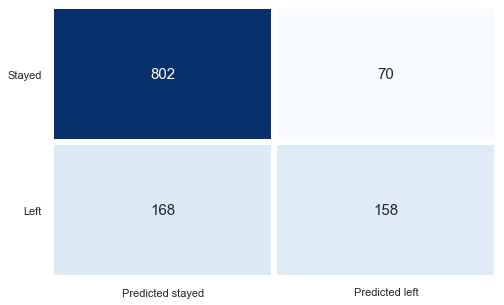

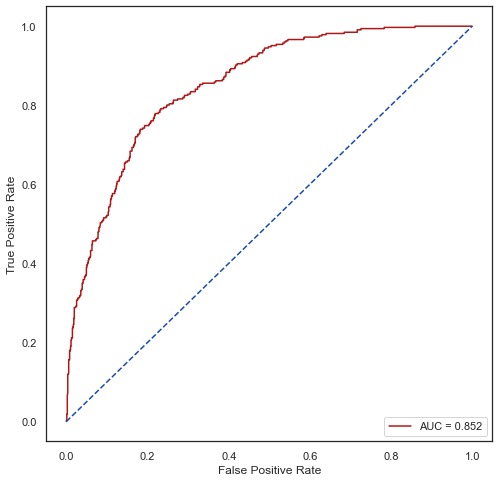

,feature,importance
14,Contract,0.276520
4,tenure,0.132730
18,TotalCharges,0.118790
8,OnlineSecurity,0.114108
11,TechSupport,0.096131
17,MonthlyCharges,0.082396
7,InternetService,0.043789
9,OnlineBackup,0.036751
16,PaymentMethod,0.023979
10,DeviceProtection,0.022167


In [49]:
rf = RandomForestClassifier(random_state = 22, max_depth = 5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 1] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 1] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 1] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 1] = round(roc_auc_score(y_test, y_prob), 3)
rf_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 5 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(rf, X, y, cv = 5, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(rf, X, y, cv = 5, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(rf, X, y, cv = 5, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(rf, X, y, cv = 5, scoring = 'f1').mean(), 2)}")

# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(rf_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
           yticklabels = ['Stayed', 'Left'], xticklabels = ['Predicted stayed', 'Predicted left'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Feature importance
f_imp2 = pd.DataFrame(columns = ['feature', 'importance'], index = range(19))
for i in range(len(f_imp2.index)):
    f_imp2.iloc[i, 0] = X_train.columns.to_list()[i]
f_imp2['importance'] = rf.feature_importances_
f_imp2 = f_imp2.sort_values('importance', ascending = False)
f_imp2[0:12].style.background_gradient(cmap = 'Blues')

# LGBM

In [50]:
lgbm = LGBMClassifier(random_state = 22, max_depth = 5, num_leaves = 50)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)
y_prob = lgbm.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 2] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 2] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 2] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 2] = round(roc_auc_score(y_test, y_prob), 3)
lgbm_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 5 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(lgbm, X, y, cv = 5, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(lgbm, X, y, cv = 5, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(lgbm, X, y, cv = 5, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(lgbm, X, y, cv = 5, scoring = 'f1').mean(), 2)}")

# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(lgbm_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
           yticklabels = ['Stayed', 'Left'], xticklabels = ['Predicted stayed', 'Predicted left'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Feature importance
f_imp3 = pd.DataFrame(columns = ['feature', 'importance'], index = range(19))
for i in range(len(f_imp3.index)):
    f_imp3.iloc[i, 0] = X_train.columns.to_list()[i]
f_imp3['importance'] = lgbm.feature_importances_
f_imp3 = f_imp3.sort_values('importance', ascending = False)
f_imp3[0:12].style.background_gradient(cmap = 'Blues')

NameError: name 'LGBMClassifier' is not defined

# XGB

In [ ]:
xgb = XGBClassifier(random_state = 22, max_depth = 5, objective = 'binary:logistic', eval_metric = 'logloss')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 3] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 3] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 3] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 3] = round(roc_auc_score(y_test, y_prob), 3)
xgb_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 5 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(xgb, X, y, cv = 5, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(xgb, X, y, cv = 5, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(xgb, X, y, cv = 5, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(xgb, X, y, cv = 5, scoring = 'f1').mean(), 2)}")

# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(xgb_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
           yticklabels = ['Stayed', 'Left'], xticklabels = ['Predicted stayed', 'Predicted left'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Feature importance
f_imp4 = pd.DataFrame(columns = ['feature', 'importance'], index = range(19))
for i in range(len(f_imp4.index)):
    f_imp4.iloc[i, 0] = X_train.columns.to_list()[i]
f_imp4['importance'] = xgb.feature_importances_
f_imp4 = f_imp4.sort_values('importance', ascending = False)
f_imp4[0:12].style.background_gradient(cmap = 'Blues')

# Conclusion

In [ ]:
plt.figure(figsize = (10, 7))
sns.heatmap(results[results.columns.to_list()].astype(float), cmap = 'Blues', annot = True, linewidths = 1, cbar = False, annot_kws = {'fontsize': 12},
           yticklabels = ['Precision', 'Recall', 'F1', 'ROC AUC'])
sns.set(font_scale = 1.5)
plt.yticks(rotation = 0)
plt.show()

**In my opinion, for a telecommunications company, it is not so much important to know exactly who will leave the company, but all those who may leave. All models without any tuning can find half of the potential customers to leave with precision of ~68%. If there were data on more customers and tune the models, it would be a great help for the company.**